# DiracPy Tutorial - Part 2

In [1]:
import matplotlib.pyplot as plt
import diracpy as dp
import numpy as np

## Quantum systems in diracpy

The `qsys` class in diracpy creates quantum systems around a given Hamiltonian. To understand what a diracpy `qsys` is and why it is needed, we need to first explain the front-end and back-end of diracpy. The front-end presents the user with the interface to define bras, kets and operators. This was covered in part 1 of this tutorial, and allows these objects to be coded in the same way they would be written in Dirac notation. The back-end supports several methods to solve the quantum dynamics under a given Hamiltonian.

Ultimately, to solve the dynamics, the abstract dirac vectors and operators must be written explicitly using lineary algebra (using numpy arrays in our case). The `qsys` class takes a Hamiltonian and the inital state of the system, then finds an appropriate basis to describe the system, and defines the Hamiltonian matrix in this basis.

## Numericall integration of the von Neumann equation

Consider the quantum system with the Jaynes-Cummings Hamiltonian
$$
    H = \sigma_z \Delta 
    + g (a^{\dagger} \sigma_- + a \sigma_+)
$$
where $g$ is the interaction strength (frequency) and $\Delta = \omega_0-\omega$ is the detuning between the resonance of a single mode cavity and a two level system.

In [35]:
# define state space
atom = dp.two_level_subspace(index=0)
cav = dp.fock_subspace(index=1)
# define model parameters
Delta, g = 0, np.pi
# define Hamiltonian
H_0 = Delta * atom.sigma_z
V = g * (cav.a * atom.sigma_plus + cav.adag * atom.sigma_minus)
H = H_0 + V

In [36]:
# Define initial state and quantum system
psi0 = dp.ket(['e',0])
system = dp.qsys(H, initialstates=[psi0], n_int=2)

In [4]:
# definine initial density operator rho0
rho0 = psi0 * psi0.conj()
# times to solve for
times = np.linspace(0,2,50)
# solve the vonneumann equation
vnsolve = dp.vonneumannint(rho0, times, system)

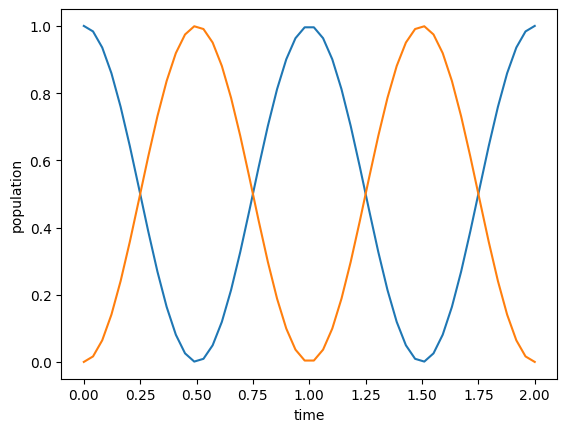

In [5]:
fig, ax = plt.subplots(1,1)
ax.plot(times, np.real(vnsolve.soln[:,0,0]))
ax.plot(times, np.real(vnsolve.soln[:,1,1]))
ax.set_xlabel('time')
ax.set_ylabel('population')
plt.show()

## Time dependent quantum systems

An example of a time dependent quantum system given by the Hamiltonian
$$
    H = \sigma_z \Delta 
    + \frac12 \Omega(t) (a^{\dagger} \sigma_- + a \sigma_+)
$$
where $\Omega(t) = \Omega \sin (\pi t)^2$ for $0<t<1$, and $\Delta = \omega_0-\omega$ is the detuning of a coherent driving field from resonance of the two level system.

In [2]:
import matplotlib.pyplot as plt
import diracpy as dp
import numpy as np

In [7]:
def f(t):
    return np.sin(np.pi * t)**2

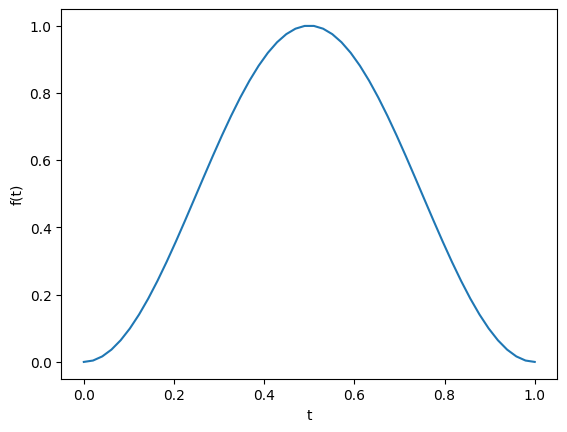

In [8]:
fig, ax = plt.subplots(1,1)
times = np.linspace(0,1,50)
ax.plot(times, f(times))
ax.set_xlabel('t')
ax.set_ylabel('f(t)')
plt.show()

We next define the state spaces for the atom and field, and the term of the hamiltonian.

In [9]:
atom = dp.two_level_subspace(index=0)
laser = dp.floquet_subspace(index=1)

Delta, Omega = 0, 10

H_0 = Delta * atom.sigma_z
V = 0.5 * Omega * (laser.a * atom.sigma_plus + laser.adag * atom.sigma_minus)

where the time dependent Hamiltonian would be given by `H_0 + f(t) * V`.
However, diracpy only recognises `f(t)*V` when a time `t` is defined and thus `f(f)` returns a scalar. Instead, define a time dependent quantum system `dp.qsys_t` and pass the static part of the Hamiltonian, `H_0`, the dynamic part `V` and the function of the dynamic coefficient, `f`.

In [10]:
psi0 = dp.ket(['g',0])
system = dp.qsys_t(H_0, [V], [f], initialstates=[psi0], n_int=2)

We can now access the time dependent Hamiltonian, which at `t=0.5` is

In [11]:
system.ham(0.5)

array([[0.+0.j, 5.+0.j],
       [5.+0.j, 0.+0.j]])

and at `t=0` is

In [12]:
system.ham(0)

array([[0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])

In [23]:
rho0 = psi0 * psi0.conj()
times = np.linspace(0,1,200)
solver = dp.vonneumannint(rho0, times, system)
# solver = dp.lindbladint(rho0, times, system)

In [24]:
solver.solve()

In [25]:
system.print_basis()

1  *  ket ('g', 0)
1  *  ket ('e', -1)


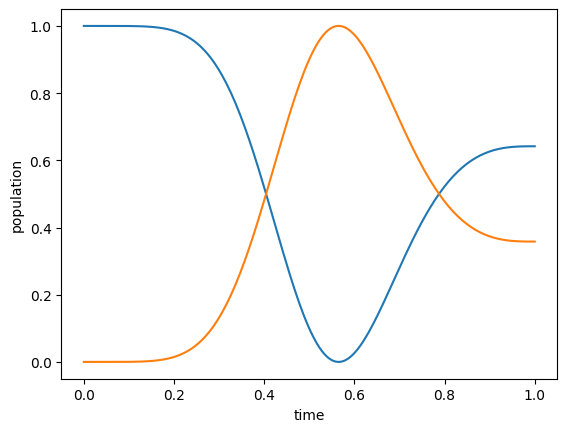

In [26]:
fig, ax = plt.subplots(1,1)
ax.plot(times, np.real(solver.soln[:,0,0]))
ax.plot(times, np.real(solver.soln[:,1,1]))
ax.set_xlabel('time')
ax.set_ylabel('population')
plt.show()

## Quantum Jumps (Monte Carlo) Simulation

In [2]:
# define state space
atom = dp.two_level_subspace(index=0)
cav = dp.fock_subspace(index=1)
# define model parameters
Delta, g ,gamma = 0, np.pi, 0.1
# define Hamiltonian
H_0 = Delta * atom.sigma_z
V = g * (cav.a * atom.sigma_plus + cav.adag * atom.sigma_minus)
H = H_0 + V

psi0 = dp.ket(['e',0])

system = dp.qsys(hamiltonian_operator=H, jump_ops=np.sqrt(gamma)*cav.a,
                 initialstates=[psi0], n_int=2)

In [26]:
times = np.linspace(0,10,200)
jpsolve = dp.quantumjumps(psi0, times, system, test=True)

In [27]:
# Evaluate the deterministic evolution between quantum jumps
jpsolve.gen_bstate_evolution()

In [28]:
# number of quantum trajectories
n = int(1e2)
# Monte Carlo simulation
mean_rho, var_rho = jpsolve.calc_rho(n)
mean_rho[-1,0,0], var_rho[-1,0,0]

((0.5499994554540468+0j), (0.5499989109086312+0j))

In [29]:
system.print_basis()

1  *  ket ('e', 0)
1  *  ket ('g', 1)
1  *  ket ('g', 0)


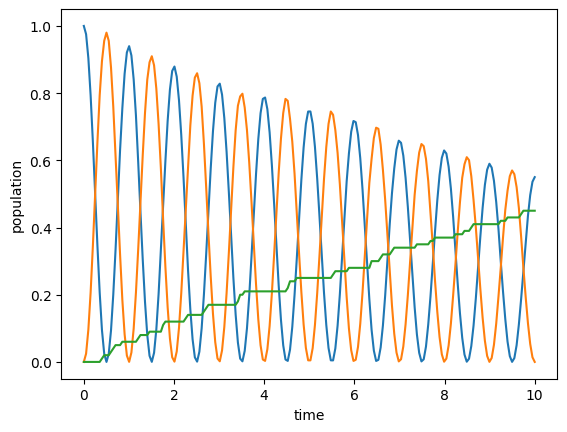

In [30]:
fig, ax = plt.subplots(1,1)
ax.plot(times, np.real(mean_rho[:,0,0]))
ax.plot(times, np.real(mean_rho[:,1,1]))
ax.plot(times, np.real(mean_rho[:,2,2]))
ax.set_xlabel('time')
ax.set_ylabel('population')
plt.show()

### Comparison to the solutions of the Lindblad master equation

In [44]:
lbsolve = dp.lindbladint(psi0*psi0.conj(), times, system)

In [45]:
lbsolve.solve()

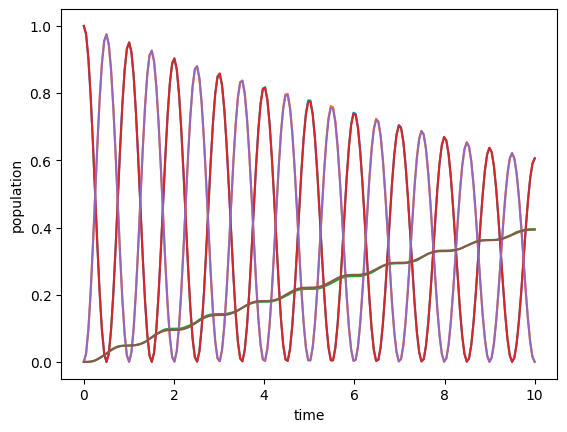

In [46]:
fig, ax = plt.subplots(1,1)
ax.plot(times, np.real(mean_rho[:,0,0]))
ax.plot(times, np.real(mean_rho[:,1,1]))
ax.plot(times, np.real(mean_rho[:,2,2]))
ax.plot(times, np.real(lbsolve.soln[:,0,0]))
ax.plot(times, np.real(lbsolve.soln[:,1,1]))
ax.plot(times, np.real(lbsolve.soln[:,2,2]))
ax.set_xlabel('time')
ax.set_ylabel('population')
plt.show()

In [35]:
system.lindbladlowering

{0: array([[0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j]])}

### Using multiprocessing for the deterministic evolution

In [2]:
from pathos.pools import ProcessPool
import time as time

To speed up the calculation using multiprocessing we can use different processors to calculate the deterministic evolution of each basis state. In this case we no longer use `jpsolve.gen_bstate_evolution()`, but calculate the evolution of each basis state (`bstate`) seperately. The method `bstate_i_evolution(i)` of `quantumjumps` calculates the deterministic evolution of the $i^{\mathrm{th}}$ basis state.  First, here is a quick demonstration of how this is done without combining with multiprocessing.

Consider the 6 mode Jaynes-Cummings model. There are enough modes that the cacluation of each basis state evolution is starting to get noticeably slow.

In [3]:
# define state space
atom = dp.two_level_subspace(index=0)
n_modes = 4
cav = []
for i in range(n_modes):
    cav.append(dp.fock_subspace(index=i+1))
# define model parameters
DeltaZ = 0
Deltas = np.linspace(0,10,n_modes)
gs = [np.pi for i in range(n_modes)]
gammas = [0.1 for i in range(n_modes)]

# initialise Hamiltonian
H = DeltaZ * atom.sigma_z
for i in range(n_modes):
    # add cavity energy terms to H
    H += Deltas[i] * cav[i].n
    # add interaction terms to H
    H += gs[i] * (cav[i].a * atom.sigma_plus + 
                  cav[i].adag * atom.sigma_minus)

In [4]:
times = np.linspace(0,20,10000)
psi0 = dp.ket(['e',1,0,0,0])
jump_operators = [np.sqrt(gamma)*mode.a for gamma, mode in zip(gammas, cav)]
big_system = dp.qsys(H, jump_ops=jump_operators,
                     initialstates=[psi0], n_int=5)

# initialise quantumjumps object.
jpsolve = dp.quantumjumps(psi0, times, big_system)

In [5]:
t0 = time.time()
for i in range(jpsolve.dim):
    jpsolve.bstate_evolution[i] = jpsolve.bstate_i_evolution(i)
t1 = time.time()
print(t1-t0)

12.76271915435791


In [6]:
t0 = time.time()
with ProcessPool(2) as pool:
    bstates_evolution = pool.map(jpsolve.bstate_i_evolution, 
                                          ((i,) for i in range(big_system.dim))
                                         )
    
for i in range(big_system.dim):
    jpsolve.bstate_evolution[i]=bstates_evolution[i]
    
t1 = time.time()
print(t1-t0)

8.47182321548462


In [7]:
# number of quantum trajectories
n = int(1e2)
# Monte Carlo simulation
mean_rho, var_rho = jpsolve.calc_rho(n)

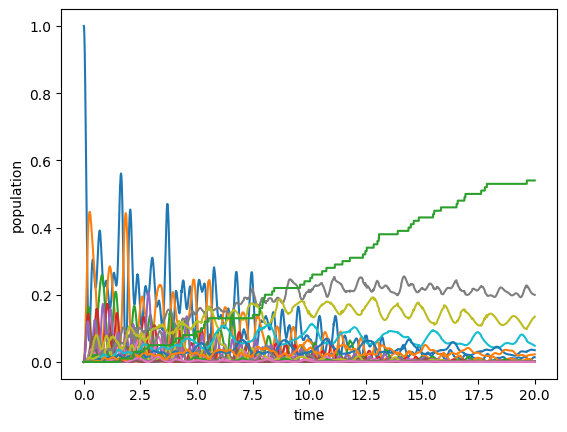

In [8]:
fig, ax = plt.subplots(1,1)
for i in range(big_system.dim):
    ax.plot(times, np.real(mean_rho[:,i,i]))
ax.set_xlabel('time')
ax.set_ylabel('population')
plt.show()

### Down sampling the deterministic solution

Often we need small time steps to capture the rapid coherent dynamics, but larger time steps suffice for the relatively slow decay processes capture by the Monte Carlo simulation. To accomodate this we can use the `bstate_i_long_evolution` method to calulate the determinstic part of the basis state evolution with shorter times steps. We use the optional named paremeter `sampleratio` to make the time steps smaller by this ratio.



In [10]:
times = np.linspace(0,20,200)
psi0 = dp.ket(['e',1,0,0,0])
jump_operators = [np.sqrt(gamma)*mode.a for gamma, mode in zip(gammas, cav)]
big_system = dp.qsys(H, jump_ops=jump_operators,
                     initialstates=[psi0], n_int=5)

# initialise quantumjumps object.
jpsolve = dp.quantumjumps(psi0, times, big_system, sampleratio=40)

In [11]:
# Solve with serial processing
t0 = time.time()
for i in range(jpsolve.dim):
    jpsolve.bstate_evolution[i] = jpsolve.bstate_i_long_evolution(i)
t1 = time.time()
print("execution time {} seconds".format(t1-t0))

9.385735988616943


In [37]:
# Solve with parallel processing
t0 = time.time()

# int number of processes optional positional argument for ProcessPool
# Default is number of CPUs
# This should be specified working with job queue e.g. SLURM.
with ProcessPool() as pool: 
    bstates_evolution = pool.map(jpsolve.bstate_i_long_evolution, 
                                          ((i,) for i in range(big_system.dim))
                                         )
    
for i in range(big_system.dim):
    jpsolve.bstate_evolution[i]=bstates_evolution[i]
    
t1 = time.time()
print("execution time {} seconds".format(t1-t0))

execution time 5.830373048782349 seconds


In [38]:
# number of quantum trajectories with serial processing
t0 = time.time()
n = int(1e3)
# Monte Carlo simulation
mean_rho, var_rho = jpsolve.calc_rho(n)
t1 = time.time()
print("execution time {} seconds".format(t1-t0))

execution time 18.003729820251465 seconds


In [39]:
# number of quantum trajectories with parallel processing
t0 = time.time()

n = int(1e3)

with ProcessPool() as pool:
    # number of trajectories for each worker process
    nodes = pool.nodes # num. process = num cpu's by default
    traj_per_node = int(n / nodes)
    trajectories = [traj_per_node for i in range(nodes - 1)]
    trajectories += [n - (nodes-1)*traj_per_node]
    # map simulation over worker processes
    results = pool.map(jpsolve.calc_rho, trajectories)

# get mean of parallel simulations
mean_rho = sum([result[0] for result in results]) / len (results)

t1 = time.time()
print("execution time {} seconds".format(t1-t0))

execution time 10.701215267181396 seconds


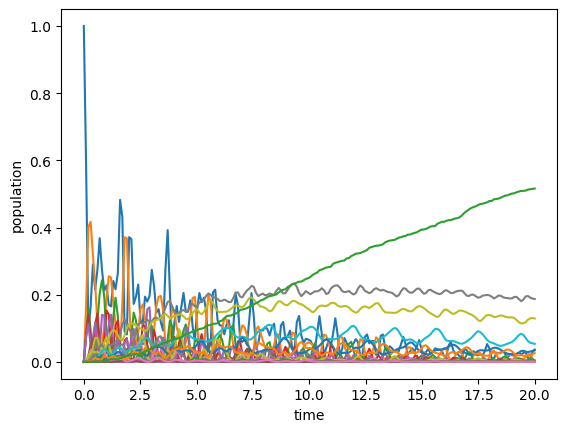

In [40]:
fig, ax = plt.subplots(1,1)
for i in range(big_system.dim):
    ax.plot(times, np.real(mean_rho[:,i,i]))
ax.set_xlabel('time')
ax.set_ylabel('population')
plt.show()

Comparing to equivalent evaluation time of Lindblad master equation using `lindbladint`.

In [42]:
# initialise lindbladint object.
times = np.linspace(0,20,8000)
lbsolve = dp.lindbladint(psi0*psi0.conj(), times, big_system)

# solve
t0 = time.time()
lbsolve.solve()
t1 = time.time()
print("execution time {} seconds".format(t1-t0))

execution time 116.56247091293335 seconds


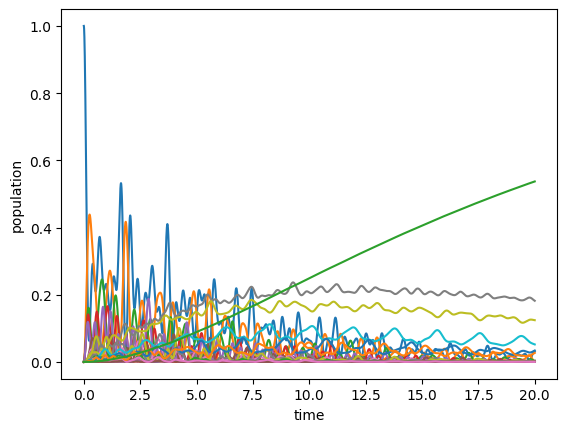

In [43]:
fig, ax = plt.subplots(1,1)
for i in range(big_system.dim):
    ax.plot(times, np.real(lbsolve.soln[:,i,i]))
ax.set_xlabel('time')
ax.set_ylabel('population')
plt.show()